# GluonCV SSD Mobilenet for Office Items Detection


1. [Introduction](#Introduction)
2. [Dataset](#Dataset)
3. [Download dataset](#Download-dataset)
4. [Train model](#Train-model)
5. [Compile model](#Compile-model)
5. [Download compiled model to the notebook instance(optional)](#Download-compiled-model-to-the-notebook-instance)
 

## Introduction

This example demonstrates finetuning and compiling an SSD Mobilenet to obtain an office items detection model for the Jetson Nano. An object detection model predicts the locations and type of objects in an image. SSD(Single Shot mutibox Detector) algorithm with MobilenetV1.0 for feature map is used in this example. Mobilenet is an efficient network for embedded devices. Also, this notebook gives an introduction to Google Open Images dataset. We download the labels, set up the training data, train, and compile the model.


__Requirements__
* Sagemaker Notebook instance with access to open-images S3 bucket
* S3 bucket

__Additional information__

Here are the links for different frameworks and models used in this neo compilation sample notebook. For basic familiarity with the modules visit the following links.

* Amazon S3 - [Amazon S3](https://aws.amazon.com/s3)
* Train model in Sagemaker - [Train model in Sagemaker](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html)
* Compilation of model - [Sagemaker Neo Compilation](https://docs.aws.amazon.com/sagemaker/latest/dg/neo.html)
* MXNet - [MXNet](https://mxnet.apache.org/)
* GluonCV - GluonCV Toolkit](https://gluon-cv.mxnet.io/)

__Kernel for notebook__

This notebook requires conda_mxnet_p36 kernel. So set the kernel of the notebook. You can select the kernel from the top right corner.
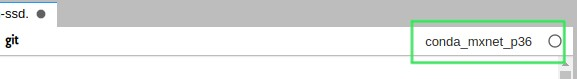

#### Import necessary python modules. 

In [1]:
import json
from collections import defaultdict
import os
import matplotlib
import matplotlib.pyplot as plt
import sagemaker
import mxnet
import boto3
import random

### Get the region of notebook instance and S3 bucket.

The notebook instance and S3 bucket should be in the same region. Notebook instance can access only the S3 bucket in the same region. If the region is same for both the instance and bucket, we can proceed with the training, else it results in an error.

Here in the following code, enter your bucket name instead of ___< my bucket name >__.

In [2]:
bucket = '< my bucket name >'

region = boto3.session.Session().region_name
s3 = boto3.client('s3')
bucket_region = s3.head_bucket(Bucket=bucket)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "Your S3 bucket {} and this notebook should be in the same region.".format(bucket)

### Sagemaker execution role and Session

IAM role for the notebook instance. We can obtain the role using the function __get_execution_role()__. We pass this role as an argument for the training job.

Session manages the interaction between Sagemaker functionalities and other AWS services. [Sagemaker Session](https://sagemaker.readthedocs.io/en/stable/api/utility/session.html#)

Default bucket - The S3 bucket to store train, labels, and output data from this training session. 

In [3]:
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session(default_bucket=bucket)
bucket = sess.default_bucket()
print('Default bucket is {}'.format(bucket))

Default bucket is evs-smk


Give the folder path in S3 bucket to store train and label data

In [4]:
 # the folder in which label file and images has to be stored.
label_data_prefix = 'office-items-detection-example/labels'
train_data_prefix = 'office-items-detection-example/images'

## Dataset

### Google Open Images V6

[Google Open Images Dataset V6](https://storage.googleapis.com/openimages/web/index.html) is created by Google Inc.  Google Open Images dataset contains ~9 million images from 6000 categories. The training images are annotated based on tasks such as image classification, object detection, segmentation, visual relationships, and local narratives. To get an overview of the classes and annotations, please visit the Open Images dataset website [Explore Google Open Images Dataset](https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=segmentation&r=false&c=%2Fm%2F0_dqb). 

The annotations are licensed by Google Inc. under CC BY 4.0 license. The images are listed as having a CC BY 2.0 license. The following paper describes the Open Images dataset in detail.

#### References 
<a id="1">[1]</a> 
_A. Kuznetsova, H. Rom, N. Alldrin, J. Uijlings, I. Krasin, J. Pont-Tuset, S. Kamali, S. Popov, M. Malloci, A. Kolesnikov, T. Duerig, and V. Ferrari._

The Open Images Dataset V4: Unified image classification, object detection, and visual relationship detection at scale.
IJCV, 2020.

[[PDF](https://arxiv.org/pdf/1811.00982.pdf)]

For this task, we use a part of the Google Open Images Dataset. The office items detection model contains 6 classes.

__Note:__ The images and annotations used in this example are not modified.


### Office items dataset

The classes of the model are __('Computer keyboard', 'Computer mouse', 'Chair', 'Computer monitor', 'Desk', 'Laptop')__. Open Images dataset contains these classes. The annotations and labels can be downloaded from the Open Images website. Here the labels and annotations are stored in a __Data__ folder. Create a folder first and download the labels to the folder.

_This step takes around 2-8 minutes._

In [5]:
!mkdir Data

In [6]:
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv -P Data/

!wget https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json -P Data/
    
!wget https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv -P Data/

!wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv -P Data/
    
!wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv -P Data/

--2020-08-10 07:10:16--  https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.23.176, 216.58.210.16, 216.58.212.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.23.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12011 (12K) [text/csv]
Saving to: ‘Data/class-descriptions-boxable.csv’

class-descriptions- 100%[===================>]  11.73K  --.-KB/s    in 0s      

2020-08-10 07:10:16 (77.7 MB/s) - ‘Data/class-descriptions-boxable.csv’ saved [12011/12011]

--2020-08-10 07:10:16--  https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.23.144, 172.217.23.176, 216.58.210.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.23.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86291 (84K) [text/cs

### Create class list

The OpenImages dataset classes are case sensitive. The classes begin with a capital letter. The exact class names can be seen from the file 'Data/class-descriptions-boxable.csv'.

In [7]:
CLASS_NAMES = ['Computer keyboard', 'Computer mouse', 'Chair', 'Computer monitor', 'Desk', 'Laptop']

Define the total number of objects required for training and validation. These images are downloaded such that the objects per class are balanced. Assign the validation ratio and text file fo classes. The data shape for the input image is (512,512).

In [8]:
NUM_OBJ = 50 # 2000 objects per class were used for training. 
VAL_RATIO = 0.15
CLASS_FILE = 'classes.lst'
RESIZE_SIZE = 512

In [9]:
# write the class names to a text file
with open(CLASS_FILE,'w') as f:
    for i in range(0, len(CLASS_NAMES)):
        f.write('{}\n'.format(CLASS_NAMES[i]))
f.close()
print('Classes are \n'+ str(CLASS_NAMES))

Classes are 
['Computer keyboard', 'Computer mouse', 'Chair', 'Computer monitor', 'Desk', 'Laptop']


In [10]:
# Find the class index and their names from the class descriptions file
def find_obj_names(label_file):
    object_names={}
    with open(label_file, 'r') as f:
        for l in f.readlines():
            idx , name = l.split(',')
            object_names[idx] = name.split('\n')[0]
    return object_names

object_names = find_obj_names('Data/class-descriptions-boxable.csv')
object_names ={val:key for key,val in object_names.items() if val in CLASS_NAMES}
print('Object names are {}\n'.format(object_names))

Object names are {'Laptop': '/m/01c648', 'Computer keyboard': '/m/01m2v', 'Chair': '/m/01mzpv', 'Desk': '/m/01y9k5', 'Computer mouse': '/m/020lf', 'Computer monitor': '/m/02522'}



In [11]:
train_data = int(NUM_OBJ)
val_data = int(NUM_OBJ * VAL_RATIO)

data_list_train = [0]*(len(CLASS_NAMES))
data_list_val = [0]*(len(CLASS_NAMES))

CLASS_IDS = [object_names[c] for c in CLASS_NAMES]

print('Number of train objects for each class {}'.format(data_list_train))
print('Number of validation objects for each class {}'.format(data_list_val))

Number of train objects for each class [0, 0, 0, 0, 0, 0]
Number of validation objects for each class [0, 0, 0, 0, 0, 0]


### Create the labels list

The labels contain image names, object names, normalized bounding boxes. The data information for bounding boxes used in this example includes 
* __ImageID__ : Name of the image (img_id)
* __Label name__: Label name, i.e., the object class
* __XMin__, __XMax__, __YMin__, __YMax__ : Normalized boundong box coordinates, always between [0,1]

__XMin - Left X, 
YMin - Top Y, 
XMax - Right X, 
YMax - Bottom Y__

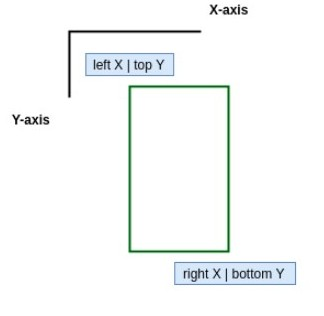

#### Reference 
[Open Images - Data formats -Bounding boxes](https://storage.googleapis.com/openimages/web/download.html)

In [12]:
def prepare_dataset(input_file= 'Data/oidv6-train-annotations-bbox.csv',num_labels=50,data_list = [],data='train',output_dict = defaultdict(list)):
    if not('.csv' in input_file):
        print('Please enter the name of a csv file')
        return
    if not(data in ['train','validation','test']):
        print('Dataset should be train, validation or test')
        return
    i=0
    output = output_dict 
    with open(input_file, 'r') as f:
        while True:
            line = f.readline()
            if line == '':
                break
            line = line.strip().split(',')
            if len(line)>=8:
                img_id, _, cls_id, conf, xmin, xmax, ymin, ymax, *_ = line
                if cls_id in CLASS_IDS:

                    pos = CLASS_IDS.index(cls_id)
                    if data_list[pos] < num_labels or img_id in output:                    
                        output[img_id].append([cls_id, xmin, ymin, xmax, ymax,data])
                        data_list[pos]+=1
                    if data_list == [num_labels]*len(CLASS_NAMES):
                        break
    f.close()
    return output

Collect the train and validation data from the data list. In case of insufficient data, we can add data from the _test-annotations-bbox.csv_ to train data to increase the dataset size.

_The following process takes around 5-10 minutes._

In [13]:
bbs_train = defaultdict(list)
bbs_val = defaultdict(list)

bbs_train = prepare_dataset(input_file= 'Data/oidv6-train-annotations-bbox.csv',
                                num_labels=train_data,
                                data_list = data_list_train,
                                data='train',
                                output_dict = bbs_train)

#optional, in case of insufficient data
"""
bbs_train = prepare_dataset(input_file= 'Data/test-annotations-bbox.csv',
                                num_labels=train_data,
                                data_list = data_list_train,
                                data='test',
                                output_dict = bbs_train)
"""

bbs_val = prepare_dataset(input_file= 'Data/validation-annotations-bbox.csv',
                    num_labels=val_data,
                    data_list = data_list_val,
                    data='validation',
                    output_dict = bbs_val)


print('Number of train objects for each class {}'.format(data_list_train))
print('Number of validation objects for each class {}'.format(data_list_val))


Number of train objects for each class [51, 50, 79, 72, 72, 52]
Number of validation objects for each class [9, 7, 7, 7, 8, 7]


In [14]:
print('Number of training images = {}'.format(len(bbs_train)))
print('Number of validation images = {}'.format(len(bbs_val)))

Number of training images = 145
Number of validation images = 21


### Optional
Since the annotations files are large, we can delete the files once the final train and validation lists are prepared.

In [15]:
!rm -r Data/oidv6-train-annotations-bbox.csv Data/validation-annotations-bbox.csv Data/test-annotations-bbox.csv

## Download dataset

Download the images in the labels list to your S3 bucket. The source bucket is __open-images-dataset__. Based on the labels list, the annotations and image id is written into ___'train.lst'___ and ___'val.lst'___ files, followed by copying those images to the destination S3 bucket. 

In [16]:
source_bucket = 'open-images-dataset'

The label format used in the file is based on GluonCV _.lst_ file format. The creation of a sample list file for a custom dataset for object detection is described [here](https://gluon-cv.mxnet.io/build/examples_datasets/detection_custom.html). 

The list file contains annotations per image in one row. The format is
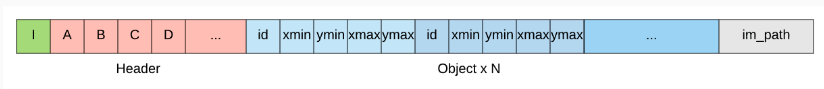
_Picture from [Custom Dataset Preparation GluonCV](https://gluon-cv.mxnet.io/build/examples_datasets/detection_custom.html)_.

The list file created in this example has values
* __header__ : 2
* __length of label__ : 5

The normalized bounding box co-ordinates are xmin, ymin, xmax, ymax.

In [17]:
import threading

global image_files

source_bucket = 'open-images-dataset'
image_files=[]
bucket = 'evs-smk'

def create_dataset(output_file, label_dict,):
    with open(output_file,'w') as lst_file:
        i=0
        for img_id_id, img_id in enumerate(label_dict.keys()):
            tmp = '{}\t2\t5\t'.format(i)
            for lbl in label_dict[img_id]:
                pos = CLASS_IDS.index(lbl[0])
                tmp += '{}\t{}\t{}\t{}\t{}\t'.format(float(CLASS_IDS.index(lbl[0])),lbl[1],lbl[2],lbl[3],lbl[4])
            
            tmp+='{}/{}.jpg'.format(lbl[5],img_id)
            image_files.append('{}/{}.jpg'.format(lbl[5],img_id))
            i=i+1
            lst_file.write(tmp+'\n')
    lst_file.close()

def copy_s3_files(filename):
    copy_source = {'Bucket' : source_bucket, 'Key': filename}
    s3.copy(copy_source, bucket, '{}/{}'.format(train_data_prefix,filename.split('/')[-1]))

In [18]:
create_dataset('train.lst',bbs_train)
print('Train data done!\n')

create_dataset('val.lst',bbs_val)
print('Validation data done!')

Train data done!


Validation data done!


In [19]:
for i in image_files:
    t= threading.Thread(target=copy_s3_files,args=(i,)).start()
print('Finished copying data to S3 bucket')

### Plot data samples

One of the images for the office items detection is plotted below. The image is from the Open Images dataset.

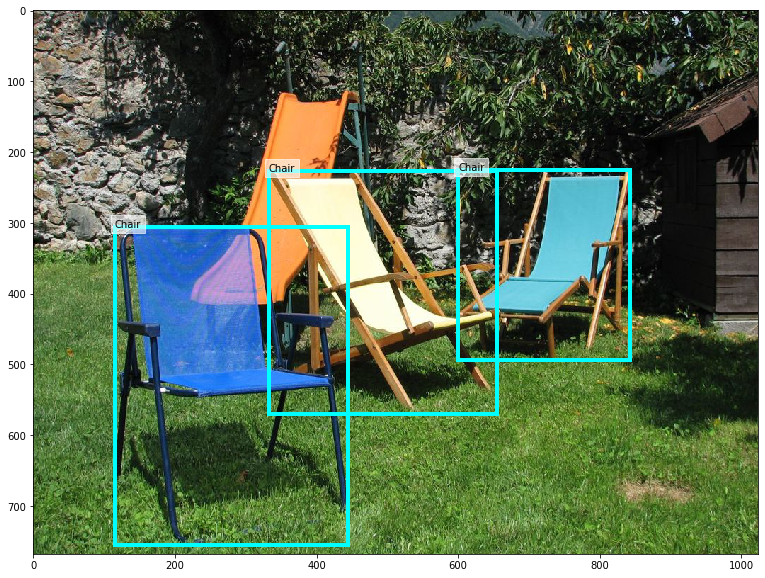

In [20]:
import random

# Plot objects in a sample validation image
class_names = []
boxes = []
sample_object = random.choice(list(bbs_val.items()))

img_id = sample_object[0]
for lbl in sample_object[1]:
    pos = CLASS_IDS.index(lbl[0])
    class_names.append(CLASS_NAMES[pos])
    boxes.append([lbl[1],lbl[2],lbl[3],lbl[4]])

copy_source = {'Bucket' : source_bucket, 'Key': '{}/{}.jpg'.format(lbl[5],img_id)}
s3.download_file('open-images-dataset', '{}/{}.jpg'.format(lbl[5],img_id),'{}.jpg'.format(img_id))

plt.figure(figsize = (20,10))
image = plt.imread('{}.jpg'.format(img_id))
h,w,_ = image.shape
j=0
for box in boxes:
    rec = plt.Rectangle((float(box[0])*w, float(box[1])* h), (float(box[2]) - float(box[0]))*w, (float(box[3])-float(box[1]))*h, fill=None, lw=4, edgecolor='cyan')
    plt.gca().add_patch(rec)
    plt.text(float(box[0])*w,float(box[1])*h, class_names[j], bbox=dict(alpha=0.6, color = 'white'))
    j=j+1
plt.imshow(image)
plt.show()
class_names = []
boxes = []


In [21]:
# Upload the label files to train and validation channels
sess.upload_data(path='train.lst', bucket=bucket, key_prefix=label_data_prefix)
sess.upload_data(path='val.lst', bucket=bucket, key_prefix=label_data_prefix)
sess.upload_data(path='classes.lst', bucket=bucket, key_prefix=label_data_prefix)

s3_label_data = 's3://{}/{}'.format(bucket,label_data_prefix)
s3_train_data = 's3://{}/{}'.format(bucket,train_data_prefix)

print(s3_label_data)
print(s3_train_data)


s3://evs-smk/office-items-detection-example/labels
s3://evs-smk/office-items-detection-example/images


## Train model

### Transfer learning

Here we use a custom Python code to train a model using estimator class MXNet(). The MXNet class used for training is derived from the Estimator class.[MXNet sagemaker](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/sagemaker.mxnet.html).

The training script contains the preparation of training data from _.lst_ file, fine-tuning the SSD-Mobilenet model based on the input hyperparameters. SSD-MobilenetV1 is chosen since MobileNets are lightweight networks with good accuracy and low computation time, hence a good choice for Jetson Nano. Since the dataset is small we use transfer learning for better results. So we initialize the network with weights from a pre-trained model. The base network is trained using  [COCO](https://cocodataset.org/#home). The COCO dataset contains similar classes as in Office Items detection models. This helps the network to learn quickly. In the fine-tuning session the last layer is replaced with new classes and the network is trained to obtain better results. The input image size for the model is 512 x 512. In this example, the hyperparameters epochs and data-shape are only initialized. The other parameters use default values. It can be set according to your training using the argument list in the _ssd_entry_officeitems_detection.py_.

* Deep learning toolkit - [GluonCV](GluonCV)
* Object detection - [SSD](https://arxiv.org/abs/1512.02325)
* MobileNet - [Mobilenet V1](https://arxiv.org/pdf/1704.04861.pdf)
* Introduction to transfer learning - [Transfer learning for Deep Learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)



The model was trained using [ml.p2.xlarge](https://aws.amazon.com/ec2/instance-types/) GPU instance. The EC2 instance price per hour is listed in [EC2 instance pricing](https://aws.amazon.com/ec2/pricing/on-demand/). 10 epochs took ~9 hours and cost ~$15. It is better to use the instance _ml.p3.2xlarge__, if training time has to be reduced. You can change the instance using the parameter __train_instance_type__ in the MXNet(). In this example __ml.p2.xlarge__ instance is used.

The __Estimator__ class in Sagemaker Python SDK is used to set the training parameters and fit the model. [Estimator sagemaker](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)


In [22]:
prefix = 'office-items-detection-example'
# output location to save model files
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

# Location to save your custom code in tar.gz format.
custom_code_upload_location = 's3://{}/{}/customcode'.format(bucket, prefix)

In [23]:
from sagemaker.mxnet import MXNet
from sagemaker.utils import name_from_base

ssd_estimator = MXNet(entry_point='ssd_entry_officeitems_detection.py',
                      role=role,
                      output_path=s3_output_location,
                      code_location=custom_code_upload_location,
                      train_instance_count=1,
                      train_instance_type='ml.p2.xlarge',
                      framework_version='1.6.0',
                      py_version='py3',
                      distributions={'parameter_server': {'enabled': True}},
                      hyperparameters={'epochs': 1,
                                       'data-shape': 512,
                                      }
                     )

Parameter distributions will be renamed to distribution in SageMaker Python SDK v2.


### Fit model

The estimator class has fit() which calls the train() in the entry point python file. We can see the logs in the output. If more information is required, we can set the log in the python code. 

__Note__: Get the current status, monitor, or change status your training from __Amazon Sagemaker -> Training Jobs -> _your training job___. The training job cannot be stopped from the notebook. If required, stop the job from __Training Jobs__. 

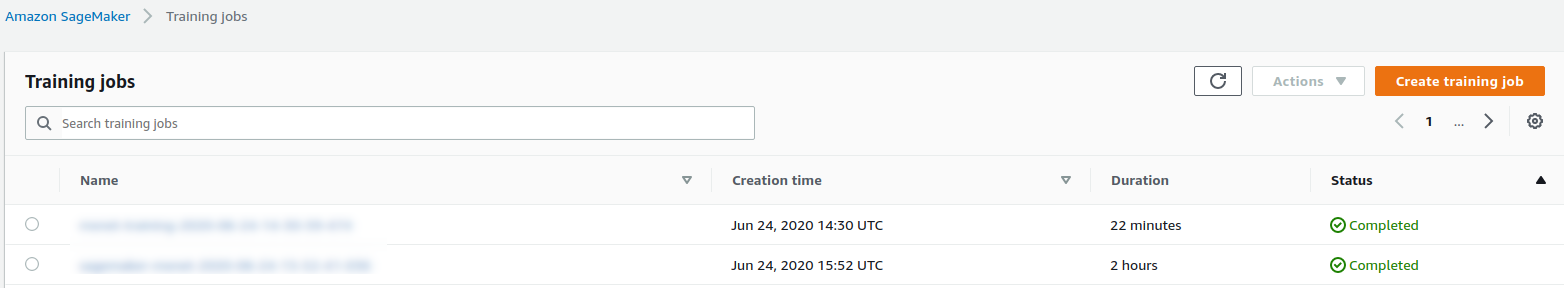

___Give a unique job name for the training. Job name should be unique similar to notebook instance name. The characters should be ^[a-zA-Z0-9](-*[a-zA-Z0-9])*___. This notebook generates a unique name for each training job. 

In [24]:
job_name = name_from_base('office-items-detection')
ssd_estimator.fit({'train': s3_train_data,'labels': s3_label_data},job_name = job_name)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-10 07:21:52 Starting - Starting the training job...
2020-08-10 07:21:55 Starting - Launching requested ML instances......
2020-08-10 07:23:01 Starting - Preparing the instances for training......
2020-08-10 07:24:05 Downloading - Downloading input data...
2020-08-10 07:24:30 Training - Downloading the training image..2020-08-10 07:25:03,710 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2020-08-10 07:25:03,736 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"data-shape":512,"epochs":1}', 'SM_USER_ENTRY_POINT': 'ssd_entry_officeitems_detection.py', 'SM_FRAMEWORK_PARAMS': '{"sagemaker_parameter_server_enabled":true}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"labels":{"RecordWrapperType":"None","S3DistributionType":"FullyReplicated","TrainingInputMode":"File"}

## Compile model

Compile the model for optimal inference on Jetson Nano. The __compile_model()__ is used for model compilation. The Sagemaker neo compiles the model in S3 output location such that the optimal model is obtained for the target device __Jetson Nano__.

For more information, please have a look at the following websites.

[Sagemaker Neo](https://docs.aws.amazon.com/sagemaker/latest/dg/neo.html)


[Neo Troubleshooting](https://docs.aws.amazon.com/sagemaker/latest/dg/neo-troubleshooting.html)

In [25]:
target_device = 'jetson_nano'
input_data = {'data':[1, 3, 512, 512]}
compiled_model = ssd_estimator.compile_model(target_instance_family=target_device,
                                             input_shape=input_data,
                                             output_path=s3_output_location,
                                             framework='mxnet', 
                                             framework_version='1.6.0'
                                            )

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


?.......!

The instance type jetson_nano is not supported to deploy via SageMaker,please deploy the model manually.


In [27]:
print('Compiled model model-jetson_nano.tar.gz can be found in {}'.format(s3_output_location))

Compiled model model-jetson_nano.tar.gz can be found in s3://evs-smk/office-items-detection-example/output


## Download compiled model to the notebook instance

Download the compiled model from S3 path to the working directory in notebook instance. 

In [28]:
compiled_model_name = '{}-{}.tar.gz'.format('model', target_device)
output = '{}/output/{}'.format(prefix,compiled_model_name)
sess.download_data('./',bucket,key_prefix=output)

### Add class list to the compiled model and upload it to the desired S3 bucket

In [29]:
!mkdir compiled_model
!mv classes.lst compiled_model/

In [30]:
command = 'tar xvf '+compiled_model_name+' -C compiled_model'
os.system(command)

0

In [ ]:
!rm -r compiled_model/dlr.h compiled_model/libdlr.so

In [31]:
new_model_name = 'office-items-detection-model.tar.gz'
command = 'tar -C compiled_model -czvf ' + new_model_name + ' .'
os.system(command)

0

In [32]:
!rm -r compiled_model/

In [34]:
# upload model to the destination bucket
prefix = 'jetson_nano_models'
model_path = sess.upload_data(path=new_model_name, key_prefix= prefix)

# prints the path to the compressed model
print('S3 file path ' +model_path)


S3 file path s3://evs-smk/jetson_nano_models/office-items-detection-model.tar.gz


## Run inferenceon Jetson Nano

Sample image after deployment on Jetson Nano. _Image from Open Images Dataset_

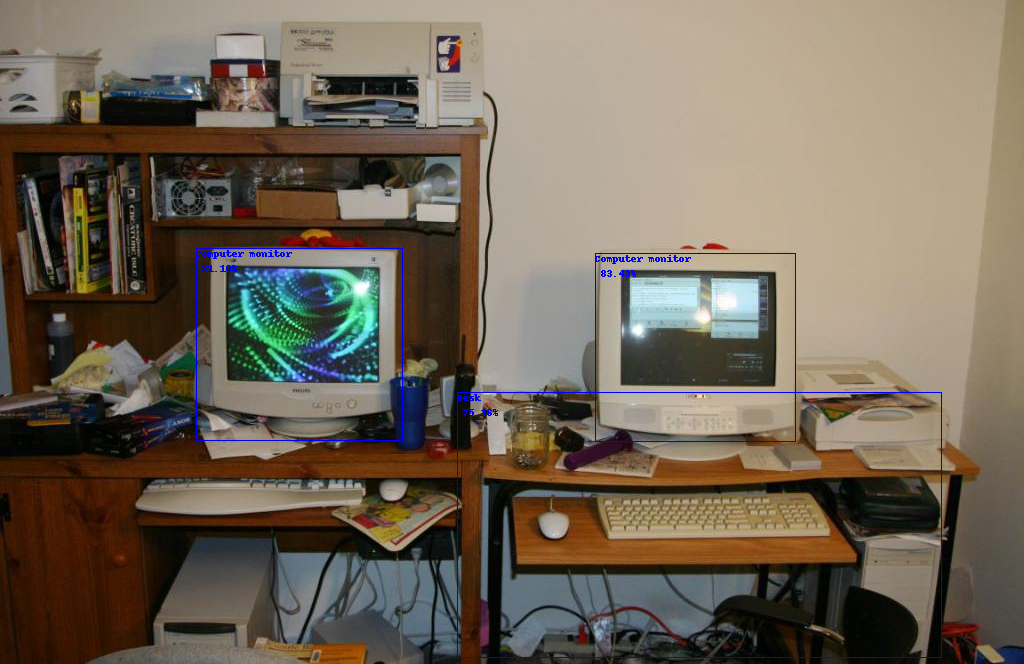